In [1]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
data = pd.read_csv('data/hydro_data.csv', sep=';')
data.head()

,Contract,Date and time,kWh,Consumption code,Average temperature (°C),Temperature code
0,312316267,2018-12-20 23:00:00,0.12,R,0,R
1,312316267,2018-12-20 22:00:00,0.19,R,0,R
2,312316267,2018-12-20 21:00:00,0.60,R,0,R
3,312316267,2018-12-20 20:00:00,0.45,R,0,R
4,312316267,2018-12-20 19:00:00,1.09,R,0,R


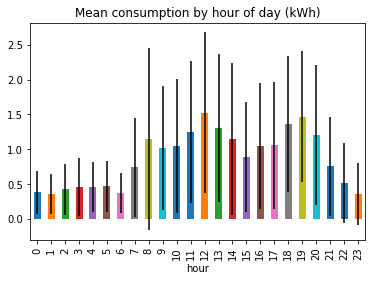

In [3]:
#A look at an average day:

def get_hour(datetime):
    return int(datetime.split(' ')[1].split(':')[0])
data['hour'] = data['Date and time'].apply(get_hour)

means = data.groupby('hour').mean()['kWh']
stds = data.groupby('hour').std()['kWh']
means.plot(kind='bar', yerr=stds, title='Mean consumption by hour of day (kWh)')

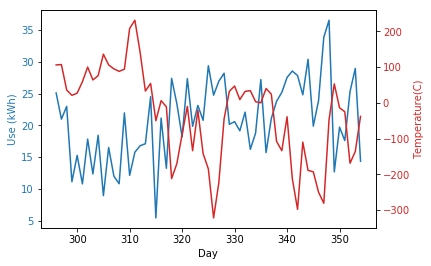

In [4]:
#A look at how the use and temperature evolve over the year: 

def get_day_of_year(datetime):
    reduced = ''.join(datetime.split(' ')[0].split('-'))
    date = pd.to_datetime(reduced, format='%Y%m%d')
    new_year_day = pd.Timestamp(year=date.year, month=1, day=1)
    day_of_the_year = (date - new_year_day).days + 1
    return day_of_the_year
data['dayofyear'] = data['Date and time'].apply(get_day_of_year)

daily_use = data.groupby('dayofyear').sum()['kWh']
daily_temp = data.groupby('dayofyear').sum()['Average temperature (°C)']

fig, ax1 = plt.subplots()
ax1.set_xlabel('Day')
ax1.set_ylabel('Use (kWh)', color='tab:blue')
ax1.plot(list(daily_use.index), list(daily_use.values), color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Temperature(C)', color='tab:red')  # we already handled the x-label with ax1
ax2.plot(list(daily_temp.index), list(daily_temp.values), color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

C:\Users\Simon\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


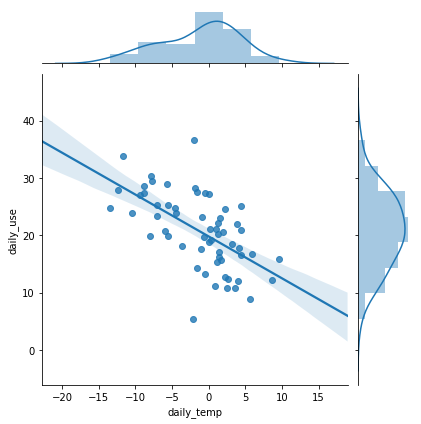

In [5]:
#Investigating the correlation between temperature and electricity consumption
temp_use = pd.DataFrame({'daily_temp': data.groupby('dayofyear').mean()['Average temperature (°C)'], 'daily_use':data.groupby('dayofyear').sum()['kWh']})
sns.jointplot(x='daily_temp', y='daily_use', data=temp_use, kind='reg')

In [6]:
#There are two outliers, which happen to be the highest and lowest use. 
#This function removes the n highest and n lowest values
def remove_extremes(n):
    for i in range(n):
        max_index = temp_use[temp_use['daily_use']==temp_use['daily_use'].max()].index[0]
        min_index = temp_use[temp_use['daily_use']==temp_use['daily_use'].min()].index[0]
        temp_use.drop(labels=[max_index, min_index], axis=0, inplace=True)
        
remove_extremes(1)

In [7]:
#Function to get cost. 
#Constants are from HydroQuebec and are accurate as of 06/01/2019
#Tarif has two tiers, with a threshold in kWh after which electricity is more expensive. Reset daily

def get_cost(use):    
    tax = 0.14975
    daily = 0.4064
    low = 0.0591
    high_thresh = 36
    high = 0.0912

    if use <=high_thresh:
        grossprice = daily + low*use
    else:
        grossprice = daily + low*use + ((use-36)*(high-low))
        
    cost = grossprice * (1+tax)   
    return(cost)

In [8]:
#First find a model for use = f(temperature), then apply electricity tarif.
from sklearn.linear_model import LinearRegression

X_train = temp_use[['daily_temp']]
y_train = temp_use['daily_use']

model = LinearRegression()
model.fit(X_train,y_train)    

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

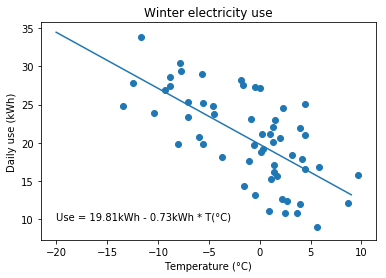

In [9]:
#Plot the cost as a function of temperature (over a sensible temperature range for winter temperatures)
def plotcost(tmin, tmax):
    plt.plot(range(tmin, tmax), [model.predict(temp)[0] for temp in range(tmin,tmax)])
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Daily use (kWh)')
    plt.title('Winter electricity use')
    
    f1 = "Use = {:.2f}kWh - {:.2f}kWh * T(°C)".format(model.intercept_ ,abs(model.coef_[0]))
    plt.annotate(f1, xy=(10,10), xytext=(-20,10))


    #Plot data alongside prediction line
    temp_use['cost'] = temp_use['daily_use']
    plt.scatter(x='daily_temp', y='daily_use', data=temp_use)
    
plotcost(-20,10)